# N-Body Simulations

This code is a brute force approach of an N-Body simulation. This means that for each time step it computes the interaction between all bodies.

## The physics of the code

In an N-body simulation, the most important thing is how we rule the interaction between the bodies. In our case, this is ruled by the gravitational force, defined as

$$ F_i = -\sum_{j\ne i}\frac{G m_i m_j(\mathbf{x_i}-\mathbf{x_j})}{(\left| \mathbf{x_i}-\mathbf{x_j} \right|^2+\epsilon^2)^{3/2}} $$

where $\mathbf{x_i}$ and $\mathbf{x_j}$ are the positions of bodies $i$ and $j$ respectively. The softening parameter $\epsilon$ avoids the divergence at $ \mathbf{x_i}=\mathbf{x_j}$.

To update the position and the velocity of each body, we've used a leapfrog integrator then this will be as:


$$x_{i+1} = x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2$$
$$v_{i+1} = v_i + \frac{1}{2} (a_i + a_{i+1}) \Delta t$$



### Scale of the system

Considering the number of bodies we can run, due to the high computational power required to run a simulation, the ideal scale to run the simulation will be the Solar System scale, then our distance will be masured in Astronomical Units (AU), the time in years (yr) and the mass in Solar Masses $\mathrm{M}_\odot$. With this we'll have that $G \approx 39.478 \frac{\mathrm{AU}^3}{\mathrm{M}_\odot \mathrm{yr}^2}$ and the system has a size of $1$ to $30\mathrm{AU}$. 

# The code for different situations 

## All the situations should start similar to this

The imports required to run a simulation. 

In [1]:
import numpy as np
import time
import pickle
import os, errno
from Initialize import Initialize
from Update import Update
import Visualization

This function will be useful when running different situations. It will create directories where to save the simulations.

In [2]:
def Create_Dir(): 
    '''
    This function has the task to create a folder, inside the directory of the program, to save the simulation.
    
    The name of the folder is determined by the date and time. It has the format (YYYYMMDD-HHMMSS).
    
    '''
    
    dirpath = os.getcwd()

    Folder = time.strftime("%Y%m%d-%H%M%S")
    
    direct = dirpath + '/' + Folder + '/' 

    #Here we make a folder to save the simulation
    
    try:
        os.makedirs(Folder)
        
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    
    return direct

## Simple example of a simulation

We'll define a function to handle the simulation. The function mainly needs the number of bodies to simulate and the steps to simulate although if we don't define any of them will run with 10 bodies and 100 steps. The function also has a flag for defining if you want to save a pickle file with the final state of the simulation. This is useful when you need to run very long simulations.

The code first initializes the bodies, then updates them (saving the plots of it's evolution), then computes the correlation function, plots it and finally check if it needs to save a pickle file.

In [3]:
def Simulation(N = 10, Pickle = False, L = 1, Steps = 100): # An example of a simulation of one group of bodies.
    
    #-------
    
    Steps = Steps
    Snaps = int(Steps/10)
    
    #-------
    
    direct = Create_Dir() # This will create a directory to save the simulation.
    
    B1 = Initialize(N, L=L,Sun=False) # Initialize the bodies.
    
    Log = open(direct + 'Log.txt','w')
    
    Log.write('System initialized with %d bodies and a box of side %d '%(len(B1),L))
    
    B2 = Update(B1,Steps=Steps,Snaps=Snaps,Plots=True,direct=direct,L=L) # Update the bodies. Since Plots = True 
                                                                         # it will save the plots for the simulation.
    
    corr = Visualization.ComputeCorr(B2, direct = direct) # Compute the correlation function 
    
    Visualization.PlotCorr(DATA = corr, direct = direct, show= True) # Plot and show the correlation function
    
    Log.write('\nSimulation done with %d steps.'%Steps)
    
    Log.close() 
    
    if Pickle == True: # Dump a pickle file with the array of bodies at the end of the simulation.
        
        picklename = direct + 'Simulation.pickle' 
    
        pickle.dump(B2,open(picklename,'wb'))

    print("The simulation has finished with %d steps."%Steps)
    
    return B2, corr, direct
 

System initialized with 20 bodies


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.30it/s]


<Figure size 432x288 with 0 Axes>

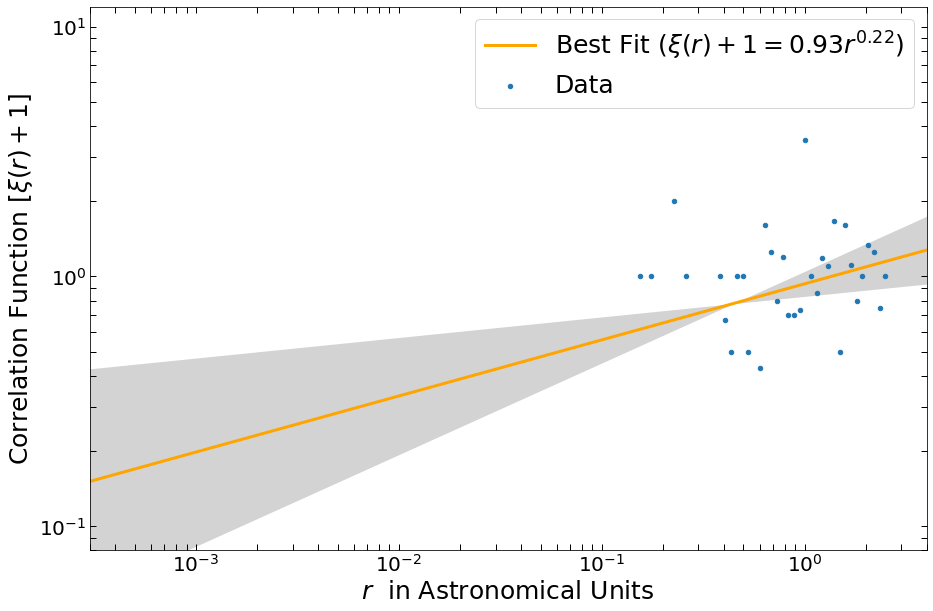

The simulation has finished with 200 steps.


In [12]:
Bod, Corr, Dir = Simulation(N = 20, Steps = 200)

For example on this small run, we see that the scale of the Correlation Function Plot is not te best. That's why we return the directory of the simulation and the data of the correlation function. This way we can re-plot the two point correlation function without having to run the whole simulation. For example:

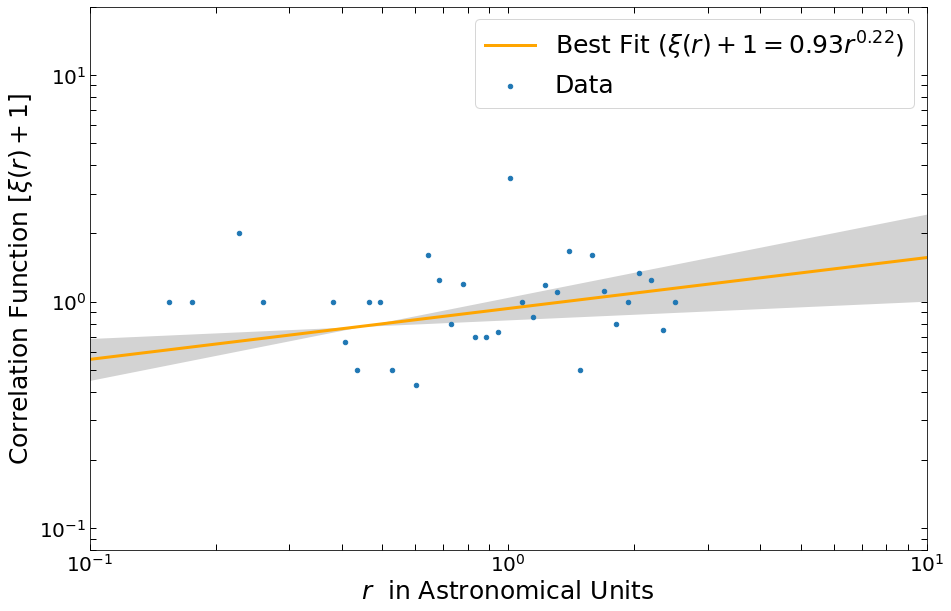

In [17]:
Visualization.PlotCorr(Corr,direct=Dir,axlims=[1e-1,1e1,8e-2,2e1],show= True)

Now this looks better (At least in the scale). This plot, once is re-plotted, it's automatically saved in the simulation directory. So, once the simulation it's done, you will end with the correlation data, the correlation plot, the snapshots, and a log file that saves some info of the simulation.

## Example with multiple group of Bodies

Now we'll build another function to simulate, in this case, 3 groups of bodies seperated a little between them. This is an interesting case to study.

The structure of the function is almost the same so it's not difficult to understand once you understand the first one above.

In [19]:
def Simulation2(N = 10, Pickle = False, L = 1, Steps = 100): # An example of a simulation of 3 groups of bodies.
 
    #-------
    
    Steps = Steps
    Snaps = (Steps/10)
    
    #-------
    
    direct = Create_Dir() # This will create a directory to save the simulation.
    
    #--- Here we initialize 3 groups of particles
    
    B1 = Initialize(N, L=L,Sun=False,Center=0.)
    
    B2 = Initialize(N,L=L,Sun=False,Center=2.)
    
    B3 = Initialize(N,L=L,Sun=False,Center=-1)
    
    #---
    
    # We stack them all in one array to be simulated later
    
    BT = np.concatenate((B1, B2, B3),axis=0) # If you want to simulate just one group, comment this line and 
                                             # update the correct body array.
        
    print('System initialized with %d bodies.'%len(BT))
                                             
    Log = open(direct + 'Log.txt','w')
    Log.write('System initialized with %d bodies and a box of side %d '%(len(BT),L))
    
    BF = Update(BT, Steps=Steps, Snaps=Snaps, Plots=True, direct=direct, L=L)# Update the bodies. Since Plots = True 
                                                                         # it will save the plots for the simulation.
    
    corr = Visualization.ComputeCorr(BF, direct = direct) # Compute the correlation Function
    
    Visualization.PlotCorr(DATA = corr, direct = direct, show = True) # Plot and show the correlation Function.
    
    Log.write('\nSimulation done with %d steps.'%Steps)
    
    Log.close() 
    
    if Pickle == True: # Dump a pickle file with the array of bodies at the end of the simulation.
        
        picklename = direct + 'Simulation.pickle' 
    
        pickle.dump(BF,open(picklename,'wb'))
    
    print("The simulation has finished with %d steps."%Steps)
    
    return BF, corr, direct
    

System initialized with 10 bodies
System initialized with 10 bodies
System initialized with 10 bodies
System initialized with 30 bodies.


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.32it/s]


<Figure size 432x288 with 0 Axes>

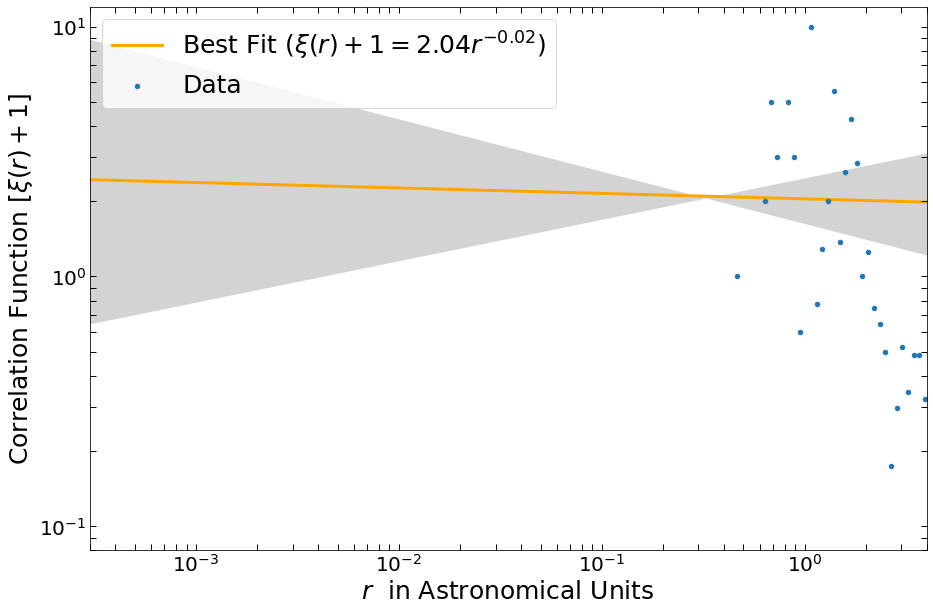

The simulation has finished with 200 steps.


In [21]:
Bod, Corr, Dir = Simulation2(N = 10, Steps = 200)

Again, we need to adjust the scale of the plot. This is a common task especially in short simulations like these.

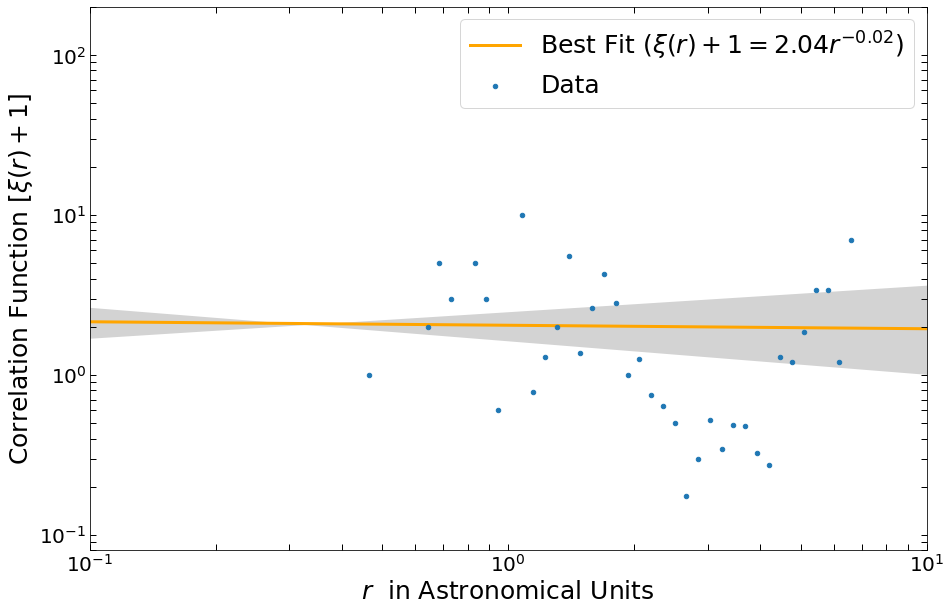

In [25]:
Visualization.PlotCorr(Corr,direct=Dir,axlims=[1e-1,1e1,8e-2,2e2],show= True)

Now this plot looks better.

## Multiple Simulations:

Also, we can run multiple simulations, although it's not quite recomended especially in systems with low RAM. This will work better with multiple small simulations. 

System initialized with 10 bodies


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.63it/s]


<Figure size 432x288 with 0 Axes>

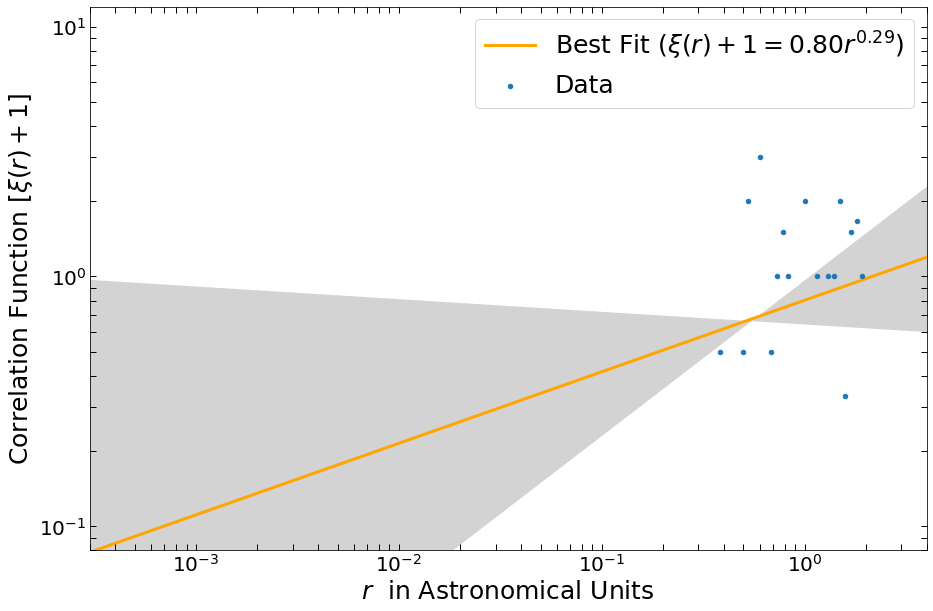

The simulation has finished with 100 steps.
System initialized with 10 bodies


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.24it/s]


<Figure size 432x288 with 0 Axes>

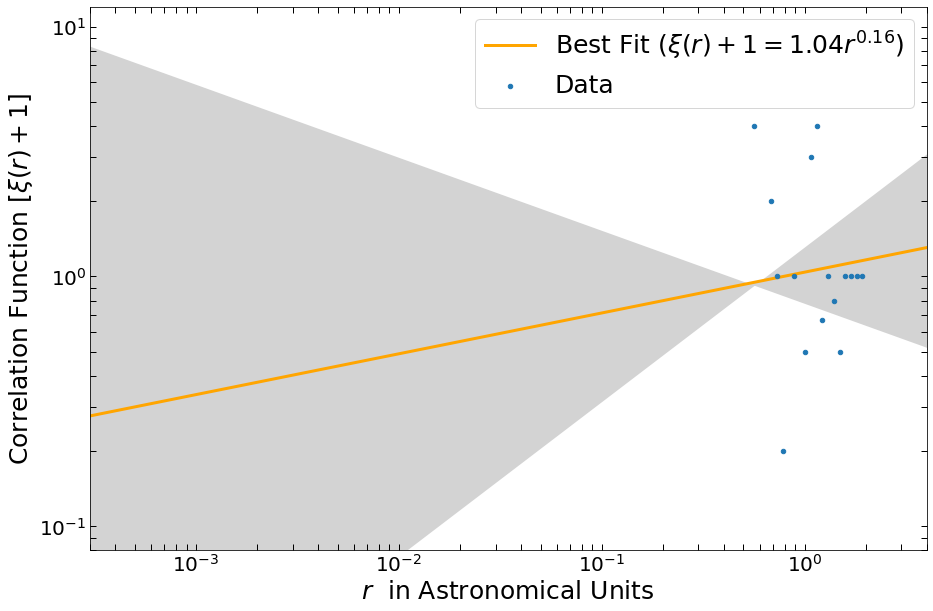

The simulation has finished with 100 steps.
System initialized with 10 bodies


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.16it/s]


<Figure size 432x288 with 0 Axes>

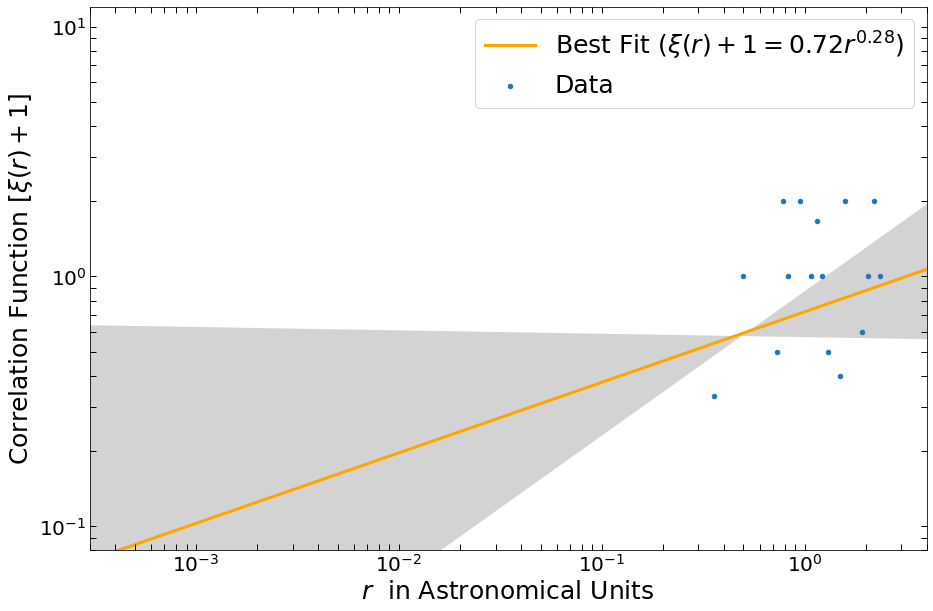

The simulation has finished with 100 steps.
System initialized with 10 bodies


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.71it/s]


<Figure size 432x288 with 0 Axes>

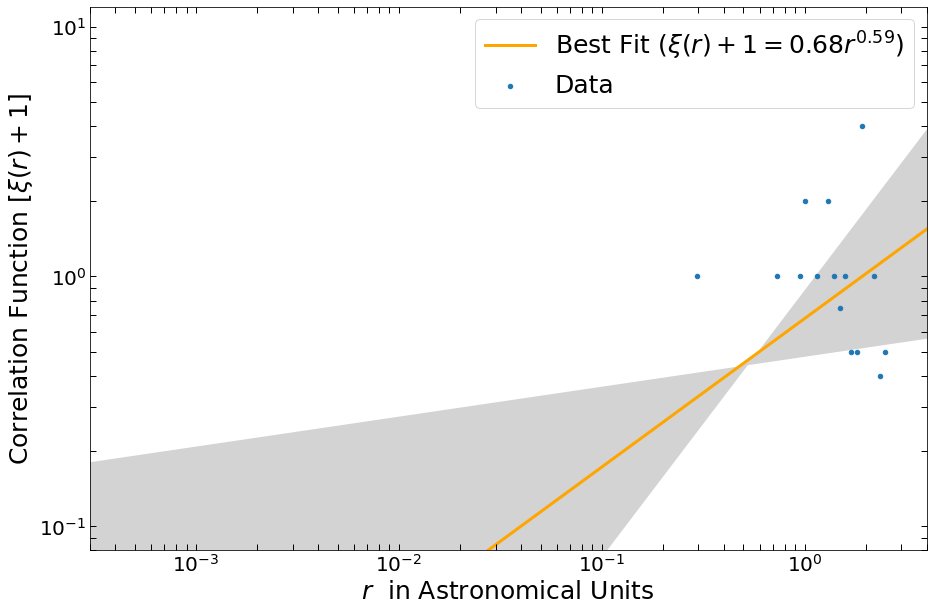

The simulation has finished with 100 steps.
System initialized with 10 bodies


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.84it/s]


<Figure size 432x288 with 0 Axes>

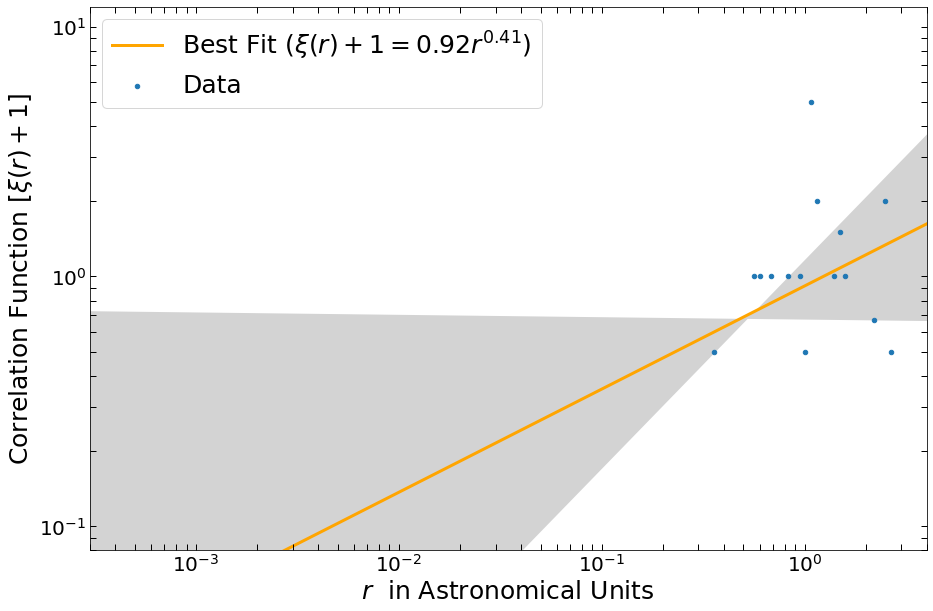

The simulation has finished with 100 steps.


In [27]:
B_arrs = []
Corr_arrs = []
direct_arrs = []

for i in range(5):
    
    B, corr, direct = Simulation(N = 10, Pickle=True, L = 1)
    
    B_arrs.append(B)
    Corr_arrs.append(corr)
    direct_arrs.append(direct)

## Running From a Pickle file:

The only difference here is that you need to specify a pickle path in the initialization function. The rest just works the same.


In [31]:
def From_Pickle(Pickle = False, L = 1, Steps = 100):
    
    #-------
    
    Steps = Steps
    Snaps = int(Steps/10)
    
    #-------
    
    pickle_dir = 'Pickle_Example.pickle'
            
    direct = Create_Dir() # This will create a directory to save the simulation.
    
    B1 = Initialize(10, Pickle = pickle_dir)
    
    Log = open(direct + 'Log.txt','w')
    
    Log.write('System initialized with %d bodies and a box of side %d '%(len(B1),L))
    
    B2 = Update(B1,Steps=Steps,Snaps=Snaps,Plots=True,direct=direct,L=L) # Update the bodies. Since Plots = True 
                                                                         # it will save the plots for the simulation.
    
    corr = Visualization.ComputeCorr(B2, direct = direct) # Compute the correlation function 
    
    Visualization.PlotCorr(DATA = corr, direct = direct, show= True) # Plot and show the correlation function
    
    Log.write('\nSimulation done with %d steps.'%Steps)
    
    Log.close() 
    
    if Pickle == True: # Dump a pickle file with the array of bodies at the end of the simulation.
        
        picklename = direct + 'Simulation.pickle' 
    
        pickle.dump(B2,open(picklename,'wb'))

    print("The simulation has finished with %d steps."%Steps)
    
    return B2, corr, direct

System initialized with 50 bodies from a Pickle file.


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.43it/s]


<Figure size 432x288 with 0 Axes>

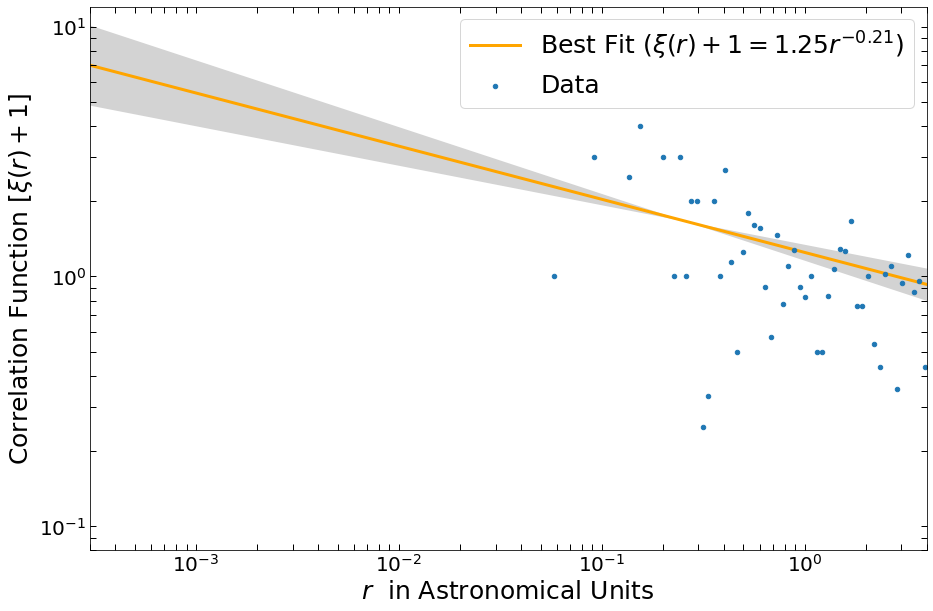

The simulation has finished with 200 steps.


In [32]:
Bod, Corr, Dir = From_Pickle(Steps = 200)

Fixing the axis of the plot

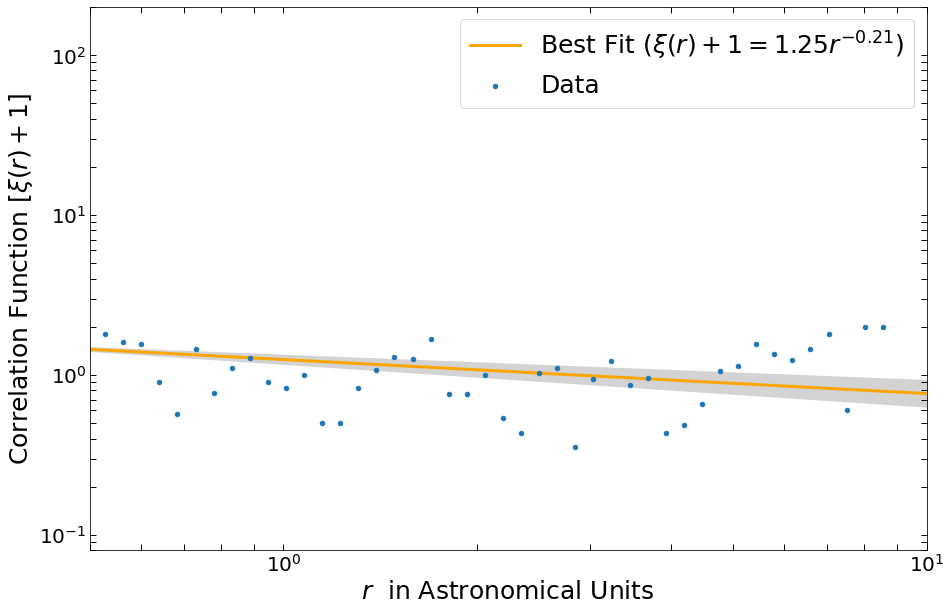

In [33]:
Visualization.PlotCorr(Corr,direct=Dir,axlims=[5e-1,1e1,8e-2,2e2],show= True)